### Ising model
Theory and implementation:
http://www.bdhammel.com/ising-model/

Implementation: only random initial state

### Cellular Potts model

Number of states: 3

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
from numpy.random import RandomState

In [2]:
%matplotlib inline

### План:
- функция рассчета объема клетки (продумать, как хранить или считать)
- дописать рассчет гамильтонинана
- настроить выбор нового положения 

In [33]:
class CellularPottsLattice:

    def __init__(self, temperature, size, interaction, lmbd, target_volume, types_num):
        self.size = size
        self.T = temperature
        self.system = self._build_system()
        self.J = interaction
        self.lmbd = lmbd
        self.vt = target_volume
        self.types_num = types_num

    @property
    def sqr_size(self):
        return (self.size, self.size)

    
    def _build_system(self):
        """Build the system
        Build a randomly distributed system
        """

        system = np.random.choice([-1, 0, 1], self.sqr_size)

        return system

    
    def _bc(self, i):
        """Apply periodic boundary condition
        Check if a lattice site coordinate falls out of bounds. If it does,
        apply periodic boundary condition
        Assumes lattice is square
        Parameters
        ----------
        i : int
            lattice site coordinate
        Return
        ------
        int
            corrected lattice site coordinate
        """
        if i >= self.size:
            return 0
        if i < 0:
            return self.size - 1
        else:
            return i
    
    
    def kronecker(self, spin_1, spin_2):
        '''Kronecker's delta. 
        1 if spin_1 == spin_2, 0 otherwise
        '''
        
        return float(spin_1 == spin_2)
    
    
    def volume(self, cell_type):
        n = 0
        for i in range(self.size):
            for j in range(self.size):
                if self.system[i, j] == cell_type:
                    n += 1
        return n
    
    
    def energy(self, N, M, E):
        
        """Hamiltonian. Calculate the energy of spin interaction at a given lattice site
             
        Parameters
        ----------
        N : int
            lattice site coordinate
        M : int
            lattice site coordinate
        E : int
            spin
        Return
        ------
        float
            energy of the site
        """
        
        # neighbors types
        type_1 = self.system[self._bc(N - 1), M] + 1
        type_2 = self.system[self._bc(N + 1), M] + 1
        type_3 = self.system[N, self._bc(M - 1)] + 1
        type_4 = self.system[N, self._bc(M + 1)] + 1
        
        energy_1 = self.J[E + 1, type_1] * (1 - self.kronecker(E, self.system[self._bc(N - 1), M]))
        energy_2 = self.J[E + 1, type_2] * (1 - self.kronecker(E, self.system[self._bc(N + 1), M]))
        energy_3 = self.J[E + 1, type_3] * (1 - self.kronecker(E, self.system[N, self._bc(M - 1)]))
        energy_4 = self.J[E + 1, type_4] * (1 - self.kronecker(E, self.system[N, self._bc(M + 1)]))
               
        # add volume calculation 
        # считать общее количество пикселей данного цвета, делить на количество клеток 
        # число клеток задается пользователем
        
        v_i = self.volume(E) / self.types_num[E+1]
        energy_volume = self.lmbd * (v_i - self.vt[E+1]) ** 2
        # calculate volume of all area with certain type 
#         volume = 
        
        energy = energy_1 + energy_2 + energy_3 + energy_4 + energy_volume
    
        return energy
    

In [34]:
def run(lattice, epochs):
    """Run the simulation
    """
          
    cmap = matplotlib.cm.Blues
    
    for epoch in range(epochs):
        
        # Randomly select a site on the lattice
        N, M = np.random.randint(0, lattice.size, 2)
        # Current energy of spin
        en = lattice.system[N, M]
                
        # Calculate energy of a flipped spin (current)
        H_current = lattice.energy(N, M, en)
        
        # Update energy of spin
        states = [(N-1, M), (N, M+1), (N+1, M), (N, M-1)]
        N_M = np.random.choice([0, 1, 2, 3], 1)
        N_new, M_new = states[N_M[0]][0], states[N_M[0]][1]
        
        while N_new == lattice.size or M_new == lattice.size:
            N_M = np.random.choice([0, 1, 2, 3], 1)
            N_new, M_new = states[N_M[0]][0], states[N_M[0]][1]
        
        en_updated = lattice.system[N_new, M_new]
        H_updated = lattice.energy(N, M, en_updated)
        
        # Calculate difference between updated and current energy
        diff = H_updated - H_current

        # New energy accepted with probabiity 
        if diff <= 0 or RandomState(424242).uniform() < np.exp(-diff/lattice.T):
            lattice.system[N, M] = en_updated

        if epoch % 1000 == 0:
            plt.figure(figsize=(10,10))
            plt.imshow(lattice.system, interpolation='nearest', cmap=cmap)
            plt.show()
            clear_output(wait=True)

In [41]:
# set parameters

t = 1        # temperature 
n = 3        # number of types
types_num = [20, 30, 10]


# interaction coefficients
J_dd = 1        
J_dl = 11
J_ll = 14
J_dm = J_lm = 16

# Lagrange multiplier
lmbd = 1

# target volume
v_t = [20, 10, 30]

s = 70     # number of sites (s x s lattice)
e = 50000  # number of iterations

In [42]:
# formation of the interaction matrix
interaction_matrix = np.zeros(shape=(3,3), dtype=int)

# 0 - dark
# 1 - medium
# 2 - light

interaction_matrix[0][0] = 2
interaction_matrix[0][1] = interaction_matrix[1][0] =\
interaction_matrix[1][2] = interaction_matrix[2][1] = 16
interaction_matrix[0][2] = interaction_matrix[2][0] = 11
interaction_matrix[2][2] = 14

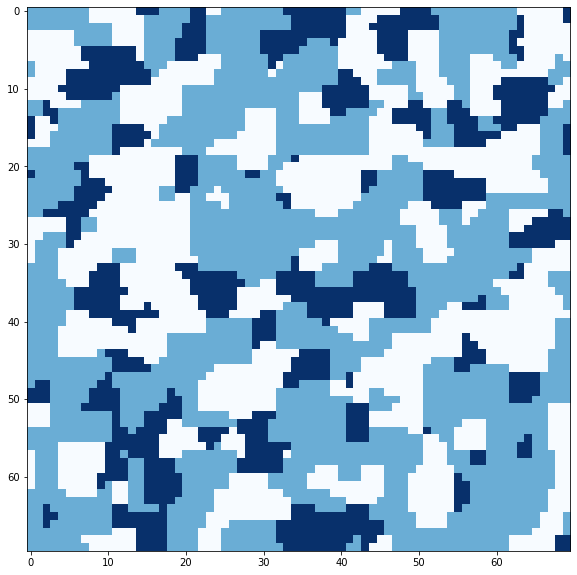

In [43]:
lattice = CellularPottsLattice(
        temperature=t, size=s, interaction=interaction_matrix, lmbd=lmbd, target_volume=v_t, types_num=types_num
    )
run(lattice, e)